In [1]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(1234)
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
tf._

In [3]:
IMG_SIZE = 28

In [4]:
# Assemble dataset
def get_matrices():

    x = pd.read_csv('./mnist/x_train.csv').to_numpy()
    y = pd.read_csv('./mnist/y_train.csv').to_numpy()
    
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size = 0.2)
    
    x_te, y_te = preprocess(x_te, y_te)
    x_tr, y_tr = preprocess(x_tr, y_tr)
    
    print('x_tr shape: '+ str(x_tr.shape))
    print('y_tr shape: '+ str(y_tr.shape))
    print('\nx_tr dtype: '+ str(x_tr.dtype))
    print('y_tr dtype: '+ str(y_tr.dtype))
    print('\nx_te shape: '+ str(x_te.shape))
    print('y_te shape: '+ str(y_te.shape))
    print('\nx_te dtype: '+ str(x_te.dtype))
    print('y_te dtype: '+ str(y_te.dtype))  
    
    return x_tr, y_tr, x_te, y_te


In [5]:
# Assemble pre-processes
def preprocess(x, y):
    
    # ohe
    y = OneHotEncoder().fit_transform(np.array(y).reshape(-1,1)).toarray()
    
    # reshape x
    x = x.reshape((x.shape[0], 28, 28, 1))
    
    # Convert greyscale to rgb
    x = np.array(list(map(grey2rgbrandomised, x)), dtype = np.float64)

    # as float
    y = y.astype('float16')
    
    # normalize
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    
    return x, y

# Pre-process functions here 
def grey2rgbrandomised(img):
    
    c = False
    filter = np.random.random(size=(3))
    image_rgb = []

    for i in range(3):
        if filter[i] < 0.20:
            image_rgb.append(img)
            c = True
        elif filter[i] < 0.60:
            image_rgb.append(255*np.ones((28,28,1), dtype = np.int))
        else:
            image_rgb.append(np.zeros((28,28,1), dtype = np.int))

    if c:
        return cv2.merge(image_rgb)
    else:
        return grey2rgbrandomised(img)
    

In [6]:
# Common functions

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_history(hist):
    fig=plt.figure()
    ax=fig.add_subplot(121)
    bx=fig.add_subplot(122)
    ax.plot(hist.history['loss'],label='loss')
    ax.plot(hist.history['val_loss'],label='val_loss')
    ax.set_title('loss')
    ax.legend()
    bx.plot(hist.history['accuracy'],label='accuracy')
    bx.plot(hist.history['val_accuracy'],label='val_accuracy')
    bx.set_title('accuracy')
    bx.legend()

In [7]:
x_tr, y_tr, x_te, y_te = get_matrices()

x_tr shape: (33600, 28, 28, 3)
y_tr shape: (33600, 10)

x_tr dtype: float64
y_tr dtype: float16

x_te shape: (8400, 28, 28, 3)
y_te shape: (8400, 10)

x_te dtype: float64
y_te dtype: float16


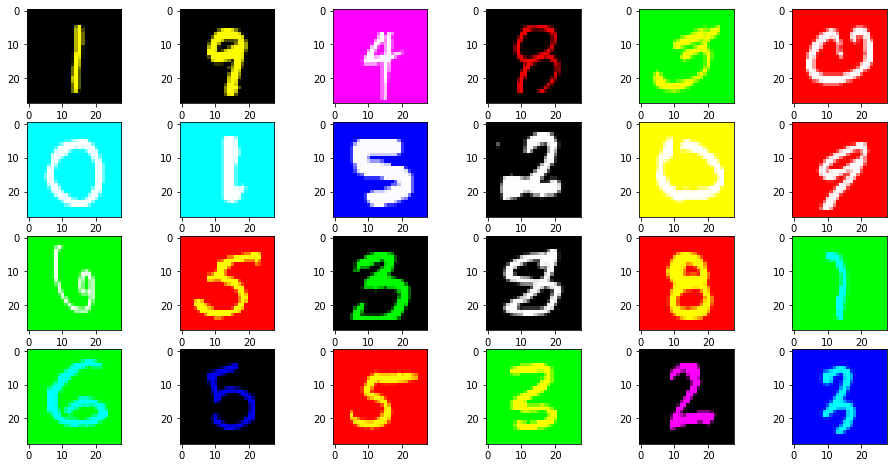

In [8]:
ind = np.random.randint(0,20000)
img = (255*x_tr[ind]).astype('int')

fig = plt.figure(figsize = (16,8))
columns = 6
rows = 4

for i in range(1, columns*rows +1):
    ind = np.random.randint(0,20000)
    img = (255*x_tr[ind]).astype('int')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Callbacks

In [10]:
class SaveLosseAndMetrics(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super(SaveLosseAndMetrics, self).__init__()
        
        self.paratha = []
    
    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        self.paratha.append(logs['loss'])

### Attempt 1

In [17]:
class BasicModel(tf.keras.Model):

    def __init__(self):
        super(BasicModel, self).__init__()
        
        # Block 1
        self.c11  = tf.keras.layers.Conv2D(35, (3,3))
        self.c12  = tf.keras.layers.Conv2D(40, (3,3))
        self.m11 = tf.keras.layers.MaxPool2D()
        self.c13  = tf.keras.layers.Conv2D(40, (1,1))
        
        # Block 2
        self.c21 = tf.keras.layers.Conv2D(40, (3,3))
        self.c22 = tf.keras.layers.Conv2D(40, (3,3))
        self.m21 = tf.keras.layers.MaxPool2D()
        self.c23  = tf.keras.layers.Conv2D(50, (1,1))
        
        # Dense Block
        self.f31 = tf.keras.layers.Flatten()
        self.d31 = tf.keras.layers.Dense(146, activation= tf.keras.activations.relu)
        self.d32 = tf.keras.layers.Dense(81, activation= tf.keras.activations.relu)
        self.d33 = tf.keras.layers.Dense(10, activation= tf.keras.activations.softmax)

    def call(self, inputs):
        
        # Block 1
        x1 = self.c11(inputs)
        x1 = self.c12(x1)
        x1 = self.m11(x1)
        x1 = self.c13(x1)
        
        # Block 2
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x1)
        x2 = self.c21(x2)
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x2)
        x2 = self.c22(x2)     
        x2 = self.m21(x2)
        x2 = self.c23(x2)
        
        # Dense Block 
        x3 = self.f31(x2)
        x3 = self.d31(x3)
        x3 = self.d32(x3)
        x3 = self.d33(x3)
        x3 = tf.clip_by_value(x3, 1e-1, 1)
        
        return x3

In [18]:
model = BasicModel()

In [19]:
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
loss=tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer,loss,metrics=['accuracy'])
model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "basic_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           multiple                  980       
_________________________________________________________________
conv2d_13 (Conv2D)           multiple                  12640     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_14 (Conv2D)           multiple                  1640      
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  14440     
_________________________________________________________________
conv2d_16 (Conv2D)           multiple                  14440     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                

In [1]:
hist = model.fit(x_tr, y_tr, epochs= 6, validation_data= (x_te, y_te),callbacks=[cb1])

In [ ]:
plot_history(hist)

### Attempt 2


In [8]:
class FeatureBlock2(tf.keras.Model):

    def __init__(self):
        super(FeatureBlock2, self).__init__()
        
        # Block 1
        self.c11  = tf.keras.layers.Conv2D(35, (3,3))
        self.c12  = tf.keras.layers.Conv2D(40, (3,3))
        self.m11 = tf.keras.layers.MaxPool2D()
        self.c13  = tf.keras.layers.Conv2D(40, (1,1))
        
        # Block 2
        self.c21 = tf.keras.layers.Conv2D(40, (3,3))
        self.c22 = tf.keras.layers.Conv2D(40, (3,3))
        self.m21 = tf.keras.layers.MaxPool2D()
        self.c23  = tf.keras.layers.Conv2D(50, (1,1))

    def call(self, inputs):
        
        # Block 1
        x1 = self.c11(inputs)
        x1 = self.c12(x1)
        x1 = self.m11(x1)
        x1 = self.c13(x1)
        
        # Block 2
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x1)
        x2 = self.c21(x2)
        x2 = tf.keras.layers.ZeroPadding2D(padding=1)(x2)
        x2 = self.c22(x2)     
        x2 = self.m21(x2)
        x2 = self.c23(x2)
        
        return x2

class DenseBlock2(tf.keras.Model):

    def __init__(self):
        super(DenseBlock2, self).__init__()
        
        self.f31 = tf.keras.layers.Flatten()
        self.d31 = tf.keras.layers.Dense(146, activation= tf.keras.activations.relu)
        self.d32 = tf.keras.layers.Dense(81, activation= tf.keras.activations.relu)
        self.d33 = tf.keras.layers.Dense(10, activation= tf.keras.activations.softmax)

    def call(self, inputs):
        
        x1 = self.f31(inputs)
        x1 = self.d31(x1)
        x1 = self.d32(x1)
        x1 = self.d33(x1)
        #x3 = tf.clip_by_value(x3, 1e-2, 1)
        
        return x1

class BasicModel2(tf.keras.Model):

    def __init__(self):
        super(BasicModel2, self).__init__()
        
        self.feature_block = FeatureBlock2()
        self.dense_block = DenseBlock2()

    def call(self, inputs):
        
        x1 = self.feature_block(inputs)
        x2 = self.dense_block(x1)
        
        return x2

In [13]:
model = BasicModel2()
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
loss=tf.keras.losses.CategoricalCrossentropy()
cb1 = SaveLosseAndMetrics()
model.compile(optimizer,loss,metrics=['accuracy'])
model.build((None, IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "basic_model2_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_block2_2 (FeatureBlo multiple                  46190     
_________________________________________________________________
dense_block2_2 (DenseBlock2) multiple                  275673    
Total params: 321,863
Trainable params: 321,863
Non-trainable params: 0
_________________________________________________________________


In [14]:
hist = model.fit(x_tr, y_tr, epochs= 3, validation_data= (x_te, y_te), callbacks=[cb1])

Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 29s 861us/sample - loss: 2.6551 - accuracy: 0.7880 - val_loss: 2.3015 - val_accuracy: 0.1124
Epoch 2/3
33600/33600 [==============================] - 29s 858us/sample - loss: 2.3017 - accuracy: 0.1100 - val_loss: 2.3013 - val_accuracy: 0.1124
Epoch 3/3
33600/33600 [==============================] - 28s 832us/sample - loss: 2.3017 - accuracy: 0.1110 - val_loss: 2.3017 - val_accuracy: 0.1124


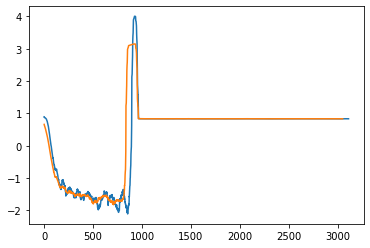

In [15]:
plt.plot(np.log(moving_average(cb1.paratha,n=40)))
plt.plot(np.log(moving_average(cb1.paratha,n=100)))

In [24]:
model.feature_block.save_weights('models/feature_block')

In [ ]:
model.load_weights()